# Projeto 2 - Classificador Automático de Sentimento

Você foi contratado por uma empresa parar analisar como os clientes estão reagindo a um determinado produto no Twitter. A empresa deseja que você crie um programa que irá analisar as mensagens disponíveis e classificará como "relevante" ou "irrelevante". Com isso ela deseja que mensagens negativas, que denigrem o nome do produto, ou que mereçam destaque, disparem um foco de atenção da área de marketing.<br /><br />
Como aluno de Ciência dos Dados, você lembrou do Teorema de Bayes, mais especificamente do Classificador Naive-Bayes, que é largamente utilizado em filtros anti-spam de e-mails. O classificador permite calcular qual a probabilidade de uma mensagem ser relevante dadas as palavras em seu conteúdo.<br /><br />
Para realizar o MVP (*minimum viable product*) do projeto, você precisa implementar uma versão do classificador que "aprende" o que é relevante com uma base de treinamento e compara a performance dos resultados com uma base de testes.<br /><br />
Após validado, o seu protótipo poderá também capturar e classificar automaticamente as mensagens da plataforma.

## Informações do Projeto

Prazo: 13/Set até às 23:59.<br />
Grupo: 1 ou 2 pessoas.<br /><br />
Entregáveis via GitHub: 
* Arquivo notebook com o código do classificador, seguindo as orientações abaixo.
* Arquivo Excel com as bases de treinamento e teste totalmente classificado.

**NÃO disponibilizar o arquivo com os *access keys/tokens* do Twitter.**


### Check 3: 

Até o dia 06 de Setembro às 23:59, o notebook e o xlsx devem estar no Github com as seguintes evidências: 
    * Conta no twitter criada.
    * Produto escolhido.
    * Arquivo Excel contendo a base de treinamento e teste já classificado.

Sugestão de leitura:<br />
http://docs.tweepy.org/en/v3.5.0/index.html<br />
https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/

___

## Preparando o ambiente

Instalando a biblioteca *tweepy* para realizar a conexão com o Twitter:

In [357]:
%%capture

#Instalando o tweepy
!pip install tweepy

Importando as Bibliotecas que serão utilizadas. Esteja livre para adicionar outras.

In [358]:
import tweepy
import math
import os.path
import pandas as pd
import json
from random import shuffle

___
## Autenticando no  Twitter

Para realizar a captura dos dados é necessário ter uma conta cadastrada no twitter:

* Conta: *** @Rebecamoreno_***


1. Caso ainda não tenha uma: https://twitter.com/signup
1. Depois é necessário registrar um app para usar a biblioteca: https://apps.twitter.com/
1. Dentro do registro do App, na aba Keys and Access Tokens, anotar os seguintes campos:
    1. Consumer Key (API Key)
    1. Consumer Secret (API Secret)
1. Mais abaixo, gere um Token e anote também:
    1. Access Token
    1. Access Token Secret
    
1. Preencha os valores no arquivo "auth.pass"

**ATENÇÃO**: Nunca divulgue os dados desse arquivo online (GitHub, etc). Ele contém as chaves necessárias para realizar as operações no twitter de forma automática e portanto é equivalente a ser "hackeado". De posse desses dados, pessoas mal intencionadas podem fazer todas as operações manuais (tweetar, seguir, bloquear/desbloquear, listar os seguidores, etc). Para efeito do projeto, esse arquivo não precisa ser entregue!!!

In [359]:
#Dados de autenticação do twitter:

#Coloque aqui o identificador da conta no twitter: @fulano

#leitura do arquivo no formato JSON
with open('auth.pass') as fp:    
    data = json.load(fp)

#Configurando a biblioteca. Não modificar
auth = tweepy.OAuthHandler(data['consumer_key'], data['consumer_secret'])
auth.set_access_token(data['access_token'], data['access_token_secret'])

___
## Coletando Dados

Agora vamos coletar os dados. Tenha em mente que dependendo do produto escolhido, não haverá uma quantidade significativa de mensagens, ou ainda poder haver muitos retweets.<br /><br /> 
Configurando:

In [360]:
#Produto escolhido:
produto = 'Nutella'

#Quantidade mínima de mensagens capturadas:
n = 500
#Quantidade mínima de mensagens para a base de treinamento:
t = 300

#Filtro de língua, escolha uma na tabela ISO 639-1.
lang = 'pt'

Capturando os dados do twitter:

In [361]:
#Cria um objeto para a captura
api = tweepy.API(auth)

#Inicia a captura, para mais detalhes: ver a documentação do tweepy
i = 1
msgs = []
for msg in tweepy.Cursor(api.search, q=produto, lang=lang).items():    
    msgs.append(msg.text.lower())
    i += 1
    if i > n:
        break

#Embaralhando as mensagens para reduzir um possível viés
shuffle(msgs)

Salvando os dados em uma planilha Excel:

In [362]:
#Verifica se o arquivo não existe para não substituir um conjunto pronto
if not os.path.isfile('./{0}.xlsx'.format(produto)):
    
    #Abre o arquivo para escrita
    writer = pd.ExcelWriter('{0}.xlsx'.format(produto))

    #divide o conjunto de mensagens em duas planilhas
    dft = pd.DataFrame({'Treinamento' : pd.Series(msgs[:t])})
    dft.to_excel(excel_writer = writer, sheet_name = 'Treinamento', index = False)

    dfc = pd.DataFrame({'Teste' : pd.Series(msgs[t:])})
    dfc.to_excel(excel_writer = writer, sheet_name = 'Teste', index = False)

    #fecha o arquivo
    writer.save()

___
## Classificando as Mensagens

Agora você deve abrir o arquivo Excel com as mensagens capturadas e classificar na Coluna B se a mensagem é relevante ou não.<br /> 
Não se esqueça de colocar um nome para a coluna na célula **B1**.<br /><br />
Fazer o mesmo na planilha de Controle.

___
## Montando o Classificador Naive-Bayes

Com a base de treinamento montada, comece a desenvolver o classificador. Escreva o seu código abaixo:

Opcionalmente: 
* Limpar as mensagens removendo os caracteres: enter, :, ", ', (, ), etc. Não remover emojis.<br />
* Corrigir separação de espaços entre palavras e/ou emojis.
* Propor outras limpezas/transformações que não afetem a qualidade da informação.



In [363]:
dft = pd.read_excel('./{0}.xlsx'.format(produto),sheet='Treinamento')
dftsim = dft[(dft.Relevante=="Sim")]
dftnao = dft[(dft.Relevante=="Não")]

In [364]:
lendo = pd.ExcelFile('./{0}.xlsx'.format(produto))
dfteste = lendo.parse("Teste")

In [412]:
#defindo funcao que limpa a frase dada removendo caracteres e se houver
def limpadorcaracter(frase):
    #rodando para cada palavra da frase recebida 
    for palavra in frase.split():
        #rodando para cada letra da palavra
        for letras in palavra:
            if letras == '@' or 'https' in palavra or 'kk' in palavra or 'kkk' in palavra:
                frase = frase.replace(palavra,"").replace('  ',' ')
            if not '@' in palavra and (letras == (",") or letras == "'" or letras == '"' or letras == '[' or letras == '‹' or letras == ']' or letras == '#' or letras == ':' or letras == ';' or letras == '›' or letras == '!' or letras == '(' or letras == ')' or letras == '/' or letras == '\n' or letras == '.' or letras == '\\' or letras == '-' or letras == '$' or letras == '%' or letras == '|' or letras == '=' or letras == '*' or letras == 'ˆ' or letras == '&' or letras == '+' or letras == ('?')):
                palavra = palavra.replace(letras," ")
                frase = frase.replace(letras," ")
    return frase

# A, S e N são dicionários com as frequências de cada uma das palavras separadas (splitadas).
A = {}
S = {}
N = {}
todas = 0
c=0
#para cada post (msg)
for msg in dft["Treinamento"]:
    #para cada palavra dentro do post (i)
    frase = limpadorcaracter(msg)
    for i in frase.split():
        #analisando cada palavra ja separada (for e if)
        #contando sua frenquencia e adicionando em A
        if not i in A:
            A[i]=0
        A[i]+=1
        todas+=1
        if A[i]>=c:
            c=A[i]
            string = i

print('Como curiosidade, a palavra que aparece com mais frequência em toda essa análise é a palavra "{0}", com uma frenquência de {1} vezes.\n'.format(string,c))
todas_em_sim = 0
p = 0
#para cada post (msg)
for msg in dftsim["Treinamento"]:
    #para cada palavra dentro do post (i)
    frase = limpadorcaracter(msg)
    for i in frase.split():
        #analisando cada palavra ja limpa
        #contando sua frenquencia e adicionando em A
        if not i in S:
            S[i]=0
        S[i]+=1
        todas_em_sim+=1
        if S[i]>=p:
            p=S[i]
            strings = i
            
print('Como curiosidade, a palavra que aparece com mais frequência entre todas as palavras de RELEVANTES é a palavra "{0}", com uma frenquência de {1} vezes.\n'.format(strings,p))
todas_em_nao = 0
f = 0
#para cada post (msg)
for msg in dftnao["Treinamento"]:
    #para cada palavra dentro do post (i)
    frase = limpadorcaracter(msg)
    for i in frase.split():
        #analisando cada palavra ja separada (for e if)
        #contando sua frenquencia e adicionando em A
        if not i in N:
            N[i]=0
        N[i]+=1
        todas_em_nao+=1
        if N[i]>=f:
            f=N[i]
            stringn = i
print('Como curiosidade, a palavra que aparece com mais frequência entre todas as palavras de NÃO RELEVANTES é a palavra "{0}", com uma frenquência de {1} vezes.\n'.format(stringn,f))
print('A quantidade TOTAL de palavras no UNIVERSO é {0}.'.format(todas))
print('A quantidade TOTAL de palavras dentro de RELEVANTES é {0}.'.format(todas_em_sim))
print('A quantidade TOTAL de palavras dentro de NÃO RELEVANTES é {0}.\n'.format(todas_em_nao))
print('A quantidade de palavras DIFERENTES no UNIVERSO é {0}.'.format(len(A)))
print('A quantidade de palavras DIFERENTES dentro de RELEVANTES é {0}.'.format(len(S)))
print('A quantidade de palavras DIFERENTES dentro de NÃO RELEVANTES é {0}.'.format(len(N)))

Como curiosidade, a palavra que aparece com mais frequência em toda essa análise é a palavra "nutella", com uma frenquência de 228 vezes.

Como curiosidade, a palavra que aparece com mais frequência entre todas as palavras de RELEVANTES é a palavra "nutella", com uma frenquência de 140 vezes.

Como curiosidade, a palavra que aparece com mais frequência entre todas as palavras de NÃO RELEVANTES é a palavra "nutella", com uma frenquência de 88 vezes.

A quantidade TOTAL de palavras no UNIVERSO é 3588.
A quantidade TOTAL de palavras dentro de RELEVANTES é 1686.
A quantidade TOTAL de palavras dentro de NÃO RELEVANTES é 1902.

A quantidade de palavras DIFERENTES no UNIVERSO é 1170.
A quantidade de palavras DIFERENTES dentro de RELEVANTES é 574.
A quantidade de palavras DIFERENTES dentro de NÃO RELEVANTES é 777.


In [366]:
#Calculando a probabilidade de cada palavra de ser relevante ou nao, para depois calcular a de cada frase de ser relevante ou nao
#Teorema de Naive Bayes: 
#P(sim|palavra)=(P(palavra|sim)+1) / P(palavras totais|sim)+P(palavras totais sem repetição)
#Em outras palavras:
#A prob de ser relevante dada a palavra é igual a prob da palavra dado que ela é relevante mais 1 
#(para o caso de a palavra nao existir no grupo de relevantes), tudo isso dividido pela prob de todas as palavras dentro de relevante
#mais a prob das palavras totais sem repeticao do universo inteiro.

bs = todas_em_sim
bn = todas_em_nao
c = len(A)
PS = {}
PN = {}
TSim = dftsim["Treinamento"].count()
TNao = dftnao["Treinamento"].count()
TTotal = dft["Treinamento"].count()
ListaPtweetS=[]
ListaPtweetN=[]
Resultado=[]
addmsgs = []

for msg2 in dfteste['Teste']:
    #Para sim:
    PtweetS = (TSim/TTotal)
    for i in msg2.split():
        #analisando cada palavra ja separada (for e if)
        for caracter in range(0,len(i)):
            i = i.strip(",").strip("'").strip('"').strip('#').strip(':').strip(';').strip('!').strip('(').strip(')').strip('/').strip('\n').strip('.').strip('\\').strip('-').strip('$').strip('%').strip('|').strip('=').strip('*').strip('ˆ').strip('&').strip('+').strip('?')
        #contando sua frenquencia e adicionando em A
        
        if i in S:
            PS[i] = (S[i]+1)/(bs+c)
            
        else:
            PS[i] = 1/(bs+c)
            
        PtweetS = PtweetS*PS[i]
    ListaPtweetS.append(PtweetS)
    addmsgs.append(msg2)
        
    #Para não:
    PtweetN = (TNao/TTotal)
    for i in msg2.split():
        #analisando cada palavra ja separada (for e if)
        for caracter in range(0,len(i)):
            i = i.strip(",").strip("'").strip('"').strip('#').strip(':').strip(';').strip('!').strip('(').strip(')').strip('/').strip('\n').strip('.').strip('\\').strip('-').strip('$').strip('%').strip('|').strip('=').strip('*').strip('ˆ').strip('&').strip('+').strip('?')
        #contando sua frenquencia e adicionando em A
        
        if i in N:
            PN[i] = (N[i]+1)/(bn+c)
            
        else:
            PN[i] = 1/(bn+c)
        
        PtweetN = PtweetN*PN[i]
    ListaPtweetN.append(PtweetN)
    #addmsgs.append(msg2)
        
for i in range(len(ListaPtweetS)):
    #Se a Probabilidade da frase for maior em Relevante do que Irrelevante, então, classifique-a como Relevante
    if ListaPtweetS[i]>ListaPtweetN[i]:
        Resultado.append("Sim")
    #Caso contrário, classifique-a como Não Relevante
    if ListaPtweetN[i]>ListaPtweetS[i]:
        Resultado.append("Não")

#criando a coluna Resultado, ou seja, os resultados do Classificador conforme as probabilidades 
#das frases de estarem ou em Relevante ou em Não Relevante
dfteste["Resultado"] = Resultado

___
## Verificando a performance

Agora você deve testar o seu Classificador com a base de Testes.<br /><br /> 

Você deve extrair as seguintes medidas:
* Porcentagem de positivos falsos (marcados como relevante mas não são relevantes)
* Porcentagem de positivos verdadeiros (marcado como relevante e são relevantes)
* Porcentagem de negativos verdadeiros (marcado como não relevante e não são relevantes)
* Porcentagem de negativos falsos (marcado como não relevante e são relevantes)

Opcionalmente:
* Criar categorias intermediárias de relevância baseado na diferença de probabilidades. Exemplo: muito relevante, relevante, neutro, irrelevante e muito irrelevante.

In [410]:
#Definindo variáveis
Igual = 0
Diferente = 0
#para cada post de Teste:
for i in range(dfteste["Teste"].count()):
    #se a resposta de Relevante for igual a resposta de Resultado entao adicione um a Igual (eles sao iguais)
    if dfteste["Relevante"][i] == dfteste["Resultado"][i]:
        Igual+=1
    else:
        Diferente+=1
        
print('{0} respostas feitas pelo Classificador coincidem com o grupo de Relevante. Ou seja, {1}% das respostas do Classificador são bem sucedidas.'.format(Igual,Igual/(Igual+Diferente)*100))
print('Enquanto que {0} respostas feitas pelo Classificador não coincidem com o grupo de Relevante. Ou seja, {1}% das respostas do Classificador são mal sucedidas.'.format(Diferente,Diferente/(Igual+Diferente)*100))

168 respostas feitas pelo Classificador coincidem com o grupo de Relevante. Ou seja, 84.0% das respostas do Classificador são bem sucedidas.
Enquanto que 32 respostas feitas pelo Classificador não coincidem com o grupo de Relevante. Ou seja, 16.0% das respostas do Classificador são mal sucedidas.


In [411]:
#definindo as variaveis para confirmar os positivos e negativos
PosFalso = 0
PosVer = 0
NegVer = 0
NegFalso = 0
#criando a lista que guardará as strings classificadoras ('Positivo Falso','Positivo Verdadeiro','Negativo Verdadeiro' e 'Negativo Falso')
PeN = []

for i in range(dfteste["Teste"].count()):
    #analisando os resultados, do mesmo post, do Classificador e do grupo Relevante feito por nós e adicionando a lista
    if dfteste["Relevante"][i]=='Não' and dfteste["Resultado"][i]=='Sim':
        PosFalso+=1
        PeN.append('Positivo Falso')

    if dfteste["Relevante"][i]=='Sim' and dfteste["Resultado"][i]=='Sim':
        PosVer+=1
        PeN.append('Positivo Verdadeiro')
        
    if dfteste["Relevante"][i]=='Não' and dfteste["Resultado"][i]=='Não':
        NegVer+=1
        PeN.append('Negativo Verdadeiro')
        
    if dfteste["Relevante"][i]=='Sim' and dfteste["Resultado"][i]=='Não':
        NegFalso+=1
        PeN.append('Negativo Falso')        

#adicinando a coluna ao DataFrame
dfteste["pn"] = PeN
#dfteste

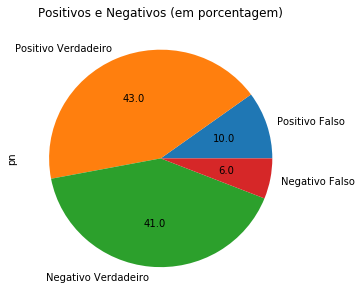

Quantidade dos respectivos Positivos e Negativos (sem porcentagem):


Positivo Verdadeiro    86
Negativo Verdadeiro    82
Positivo Falso         20
Negativo Falso         12
Name: pn, dtype: int64

In [413]:
import matplotlib.pyplot as plt
k = dfteste.pn.value_counts()/len(PeN)*100
s = k.reindex(['Positivo Falso','Positivo Verdadeiro','Negativo Verdadeiro','Negativo Falso'])
plot = s.plot(kind='pie',title='Positivos e Negativos (em porcentagem)',autopct='%.1f',figsize=(5, 5))
plt.show()

#fazendo tabelas
# pnRes = pd.crosstab(dfteste.pn,dfteste.Resultado,margins=True,rownames=['Positivos e Negativos'], colnames=['Resultado'])
# pnRel = pd.crosstab(dfteste.pn,dfteste.Resultado,margins=True,rownames=['Positivos e Negativos'], colnames=['Relevante'])
# print('Quantidade dos respectivos Positivos e Negativos do Classificador:\n')
# print(pnRes) 
# print('\n') 
# print('Quantidade dos respectivos Positivos e Negativos do grupo Relevante:\n')
# print(pnRel)

print('Quantidade dos respectivos Positivos e Negativos (sem porcentagem):')
dfteste.pn.value_counts()

        Neste gráfico de setor, percebemos que a porcentagem de positivos verdadeiros e de negativos verdadeiros classificados é de 43% e 41%, respectivamente, o que significa que, em sua maioria, o Classificador usado funciona para 84% dos casos (a soma dos dois verdadeiros). Com isso, concluimos que, como as respostas do nosso Classificador coincidem 168 vezes dentre 200 (84%), ele poderia melhorar, chegando perto de 100% de sucesso, entretanto nunca chegaria a acertar as 200 vezes.

___
## Concluindo

Escreva aqui a sua conclusão.<br /> 
Faça um comparativo qualitativo sobre as medidas obtidas.<br />
Explique como são tratadas as mensagens com dupla negação e sarcasmo.<br />
Proponha um plano de expansão. Por que eles devem continuar financiando o seu projeto?<br />

Opcionalmente: 
* Discorrer por que não posso alimentar minha base de Treinamento automaticamente usando o próprio classificador, aplicado a novos tweets.
* Propor diferentes cenários de uso para o classificador Naive-Bayes. Cenários sem intersecção com este projeto.
* Sugerir e explicar melhorias reais no classificador com indicações concretas de como implementar (não é preciso codificar, mas indicar como fazer e material de pesquisa sobre o assunto).
